### Final Project CS50
### Daniël van der Poel

## Import libraries

In [1]:
#  Data structures
import numpy as np
import pandas as pd
import pickle

#  Metrics
import scipy.stats as st
from sklearn import metrics

#  Visualisation
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

#  Modelling and evaluation
import xgboost as xgb
from sklearn.model_selection import train_test_split

#  Styling and control
%precision 3
%matplotlib inline
from IPython.display import display
from IPython.display import Markdown
pd.options.mode.chained_assignment = None

#  Custom modules, located in ./modules
import sys
sys.path.insert(0, r'.\modules')
from ml_helpers import *
from lc_helpers import *
from create_sets import create_sets
from engineer_features import engineer_features
from engineer_target_feature import engineer_target_feature
from xgb_train import xgb_train
from xgb_evaluate import xgb_evaluate
from load_data import load_data

#  General variables
VERSION = set_version(r'.\objects\lc_version.dat')
iteration = 0
print(f'Version: {VERSION}')

Sucessfully opened .\objects\lc_version.dat
Version: 5


## Load data

In [2]:
%%time

"""
The csv are supported to be located in the .\data directory. I've included only one of the files
on Github because of their sizes. You can download the other (zipped) files from the LendingClub
website. Example URL: https://resources.lendingclub.com/LoanStats_2016Q1.csv.zip
"""

raw_data = load_data('s')

Loading dataset 2016q1 Wall time: 3.86 s


## Create training, cross-validation and test sets

In [3]:
%%time

id_col = 'id'
target_cols = ['loan_status']
datestamp = 'datestamp'
data = create_sets(raw_data, id_col, target_cols, datestamp=datestamp, eval_size=0.2, test_size=.2)

Preparing data
Splitting dataset 2016q1 
Dropping 0 samples without a target value
Initial number of samples: 80,331 training, 26,778 cross-validation, 26,778 test
Initial number of features: 144
Wall time: 2.1 s


## Explore features

In [4]:
#  Explore non-numerical values
nonnumeric_cols = data.select_dtypes(include=['object']).columns
print(f'Non-numerical features: {len(nonnumeric_cols)}')
uniques(data[nonnumeric_cols], max_length=6, max_shown=6)

Non-numerical features: 38


,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,set,loan_status
type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
count,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887
unique,2,90,7,35,46274,12,3,3,3,2,7,12,13,891,50,633,1119,2,23,3,24,2,1,2,1,9,3,11,12,11,4,2,2,17,3,18,3,7
NaN,,,,,89816.7%,,,,,,133877100.0%,,106217.9%,,,,710.1%,,1480.1%,4869336.4%,20.0%,,13122698.0%,,13311399.4%,13311399.4%,13311399.4%,13311399.4%,13311399.4%,13311399.4%,13311399.4%,,,13280099.2%,13280099.2%,13280099.2%,,
1,36 mo…9612071.8%,11.99…88836.6%,B4026730.1%,C188856.6%,Teache…25431.9%,10+ ye…4634734.6%,MORTGA…6682949.9%,Source…5042537.7%,Mar-20…6199246.3%,n13363599.8%,40.0%,debt_c…7668757.3%,Debt c…7043752.6%,750xx14641.1%,CA1833113.7%,Aug-20…9750.7%,0%5150.4%,w11293184.3%,Nov-20…8220861.4%,Dec-20…8515863.6%,Nov-20…10271076.7%,Indivi…13122698.0%,Not Ve…26612.0%,N13353299.7%,INTERE…7740.6%,NATURA…3190.2%,ACTIVE3550.3%,Sep-20…3150.2%,Nov-20…2600.2%,Sep-20…2370.2%,Late (…2910.2%,Cash13215498.7%,N13280099.2%,Oct-20…2070.2%,ACTIVE8570.6%,Oct-20…1850.1%,train8033160.0%,Curren…7993159.7%
2,60 mo…3776728.2%,5.32…80606.0%,C3677727.5%,B385206.4%,Manage…23061.7%,2 year…118498.9%,RENT5086438.0%,Not Ve…4710035.2%,Feb-20…3952929.5%,y2520.2%,I rece…10.0%,credit…3218724.0%,Credit…2929121.9%,945xx13931.0%,TX115238.6%,Aug-20…9630.7%,57%3160.2%,f2095615.7%,Oct-20…41773.1%,Nov-20…230.0%,Oct-20…46013.4%,Joint …26612.0%,,Y3550.3%,,UNEMPL…1170.1%,COMPLE…2800.2%,Oct-20…1400.1%,Dec-20…1840.1%,Oct-20…2150.2%,Curren…2580.2%,Direct…17331.3%,Y10870.8%,Nov-20…1940.1%,COMPLE…1630.1%,Aug-20…1280.1%,test2677820.0%,Fully …3565026.6%
3,,9.75…62634.7%,A2648219.8%,B485076.4%,Owner16831.3%,3 year…107358.0%,OWN1619412.1%,Verifi…3636227.2%,Jan-20…3236624.2%,,I'm lo…10.0%,home_i…86626.5%,Home i…80906.0%,112xx12721.0%,NY104727.8%,Sep-20…9570.7%,55%3100.2%,,Mar-20…35602.7%,Jan-20…130.0%,Sep-20…35452.6%,,,,,EXCESS…1070.1%,BROKEN1390.1%,Aug-20…690.1%,Jan-20…680.1%,Nov-20…730.1%,In Gra…2030.2%,,,Sep-20…1580.1%,BROKEN670.1%,Sep-20…1270.1%,eval2677820.0%,Charge…130439.7%
4,,10.75…62024.6%,D1645412.3%,B582876.2%,Regist…10400.8%,< 1 ye…100827.5%,,,,,I have…10.0%,other71325.3%,Other68305.1%,606xx12320.9%,FL94357.0%,Sep-20…9420.7%,58%3070.2%,,Aug-20…32172.4%,,Aug-20…30552.3%,,,,,MEDICA…700.1%,,Nov-20…670.1%,Oct-20…680.1%,Jun-20…630.0%,Late (…220.0%,,,Jul-20…1050.1%,,Jun-20…1190.1%,,Late (…31572.4%
5,,11.47…61944.6%,E95407.1%,A180606.0%,RN10080.8%,n/a89446.7%,,,,,I woul…10.0%,major_…29232.2%,Major …27372.0%,300xx11870.9%,IL53894.0%,Aug-20…9060.7%,56%3070.2%,,Jun-20…30282.3%,,Jun-20…24971.9%,,,,,INCOME…670.1%,,May-20…660.0%,Aug-20…590.0%,Aug-20…570.0%,,,,Aug-20…1010.1%,,Jul-20…1090.1%,,In Gra…16371.2%
6,,12.99…57534.3%,F34822.6%,B277825.8%,Superv…9660.7%,1 year87036.5%,,,,,"Hello,…10.0%",medica…14571.1%,Medica…13761.0%,331xx10990.8%,NJ48033.6%,Aug-20…9060.7%,61%2990.2%,,Jul-20…29792.2%,,Jul-20…24521.8%,,,,,REDUCE…460.0%,,Jun-20…620.0%,Sep-20…540.0%,Jul-20…510.0%,,,,Jun-20…970.1%,,Nov-20…950.1%,,Late (…4580.3%


In [5]:
#  Explore numerical values
numeric_cols = data.select_dtypes(exclude=['object']).columns
print(f'Numerical features: {len(numeric_cols)}')
uniques(data[numeric_cols], max_length=6, max_shown=3)

Numerical features: 107


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,datestamp
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
count,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887,133887
unique,1397,1397,1419,20812,11324,0,4966,23,6,125,122,61,20,43750,115,42007,43637,99066,99560,54105,93252,1739,5244,5321,54139,10,160,1,940,1701,4,4706,105463,17,42,17,24,272,65691,198,25,40,21320,156,6162,25,48,37,44,39120,34753,1188,8,522,442,666,198,145,25,357,125,26,129,32,31,43,43,51,92,55,84,40,60,3,4,20,27,472,162,9,20,102434,79079,3551,68480,0,0,0,0,0,0,0,0,0,0,0,1,751,1,30,619,774,718,1071,143,28,1
NaN,,,,,,133887100.0%,170.0%,,10.0%,6456548.2%,11021682.3%,,,,,,,,,,,,,,,,9581371.6%,,13122698.0%,13122898.0%,,,,620.0%,610.0%,610.0%,610.0%,37012.8%,610.0%,1787913.4%,610.0%,610.0%,610.0%,670.1%,,610.0%,620.0%

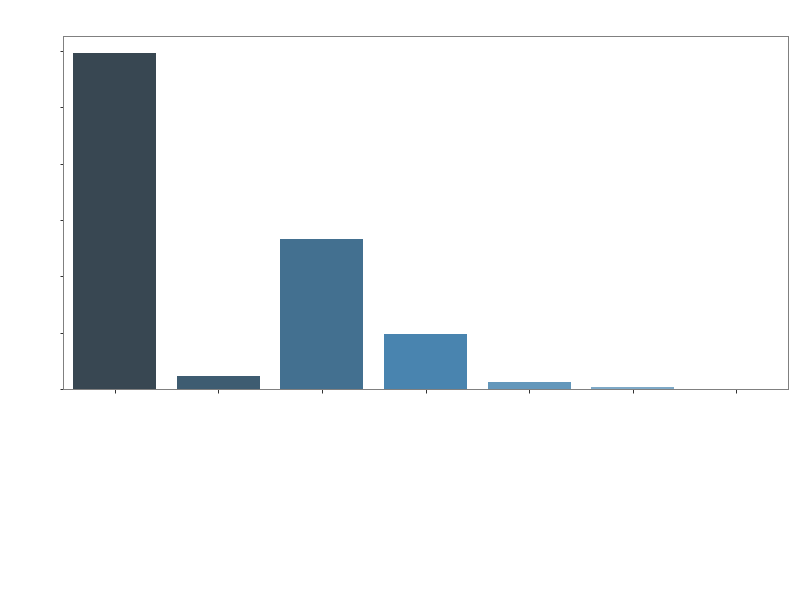

In [6]:
plot_perc(data['loan_status'], 'Target feature', filename=r'.\images\target_feature_initial.png')

## Categorise features

In [7]:
binary_cols = set([
    'term', 'pymnt_plan', 'initial_list_status', 'application_type', 'verification_status_joint',
    'disbursement_method', 'debt_settlement_flag', 'hardship_flag', 'hardship_type', 
    'deferral_term', 'disbursement_method'])

nominal_cols = set([
    'emp_title', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'hardship_reason'])

ordinal_cols = set([
    'sub_grade', 'verification_status', 'home_ownership', 'hardship_status', 'hardship_loan_status',
    'settlement_status'])

interval_cols = set([
    'loan_amnt', 'funded_amnt', 'funded_amnt_int', 'int_rate', 'installment', 'emp_length',
    'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
    'moths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_until', 'total_acc',
    'out_prncp', 'out_prncp_inv', 'tota_pymnt_inv', 'total_rec_prncp', 'total_rec_prncp', 'total_rec_int',
    'total_rec_lage_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mnths_ex_nmed',
    'mnths_since_last_major_derog', 'annuual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m',
    'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
    'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
    'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_amount',
    'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'settlement_amount',
    'settlement_percentage', 'settlement_term', 'issue_d', 'earliest_cr_line',
    'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_start_date', 'hardship_end_date', 
    'payment_plan_start_date', 'debt_settlement_flag_date', 'sec_app_earliest_cr_line', 
    'settlement_date', datestamp])

date_cols = set([
    'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
    'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
    'debt_settlement_flag_date', 'settlement_date', 'sec_app_earliest_cr_line', datestamp])

# These features are likely a result of the problems we're trying to predict, so ignore them
cheat_cols1 = ['last_pymnt_d', 'last_pymnt_amnt', 'total_rec_late_fee']

cheat_cols2 = ['last_pymnt_d', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_prncp',
             'total_pymnt', 'total_pymnt_inv'] 

# These features turned out to be very weak predictors
unimportant_cols = pickle_or_alt(r'.\objects\lc_xgb_features_default.dat', False)
unimportant_cols = unimportant_cols['unimportant'] if unimportant_cols is not False else []

# These features turned out to have a relatively high predictive value
keep_only_cols = pickle_or_alt(r'.\objects\lc_xgb_features_default.dat', False)
keep_only_cols = keep_only_cols['ranked'][:10] if keep_only_cols is not False else []

Could not open .\objects\lc_xgb_features_default.dat
Could not open .\objects\lc_xgb_features_default.dat


## Engineer features

In [8]:
%%time

engineer_params = {'input_df': data,
                   'target_cols': target_cols,
                   'ordinal_cols': ordinal_cols,
                   'interval_cols': interval_cols,
                   'date_cols' : date_cols,
                   'cheat_cols': cheat_cols1,
                   #'unimportant_cols': unimportant_cols, 
                   #'keep_only_cols': keep_only_cols,
                   'datestamp': datestamp,
                   'max_nan': .666,
                   'min_frequency': 1.0,
                   'normalise': False,
                   'rem_corr': True,
                   'max_corr': 1.0,
                   'deskew': False}

positives = ['late (16-30 days)', 'late (31-120 days)', 'default', 'charged off']
X_y = engineer_features(**engineer_params)
X_y, target_cols = engineer_target_feature(X_y, target_cols, positives)

Engineering features
0 out of 80,331 samples contained more than 96 NaN values and were dropped
Converting all strings to lowercase
Converting ordinals, binaries and number-like strings to integers
Converting datestamps to integers
Converting zipcodes to triple integers
Converting descriptions and job titles to string length integers
Converting title to shortlist
Dropping 3 cheat features
10 feature columns were replaced by 88 dummy columns
Dropping 14 imbalanced features (100.00% frequency threshold)
Removing 1 feature with intercorrelation 100.000% or more
...
Engineering target feature
Final number of samples: 80331 training, 26778 cross-validation, 26778 test
Final number of features: 205
Target feature: 87.550% 0s, 12.450% 1s
Wall time: 21.2 s


## Plot target value distribution (after engineering)

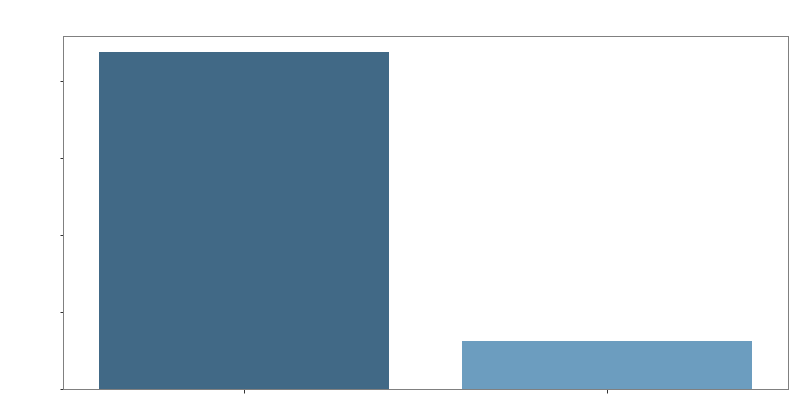

In [9]:
ratio_0_1 = len(X_y[X_y[target_cols[0]] == 0][target_cols[0]]) / len(X_y[X_y[target_cols[0]] == 1][target_cols[0]])
plot_perc(X_y['loan_status'], f'Target feature - ratio 0:1 = {ratio_0_1:.0f}', filename=r'.\images\target_feature_engineered.png')

## Save engineered data (e.g. for grid searches)

In [10]:
#  Save data object to file
pickle_save(X_y, './objects/lc_data_engineered_' + str(VERSION) + '.dat')

Sucessfully saved ./objects/lc_data_engineered_5.dat


True

## Train model

In [11]:
%%time

"""
Notes on the parameters:
- AUC is used to evaluate the model while training, because this works well with imbalanced targets
- max_depth is 7, because of the complexity required
- max_delta_step is 5 and scale_pos_weight 2.25 to help with training the imbalaned target
- n_jobs is 8, but should be set to whatever number of threads your CPU supports
- The parameters were optimised for the 'l'-sized set
"""

xgb_params = txt_to_dict(r'.\settings\xgb_params.txt')
xgb_params['scale_pos_weight'] = xgb_params['scale_pos_weight_factor'] * ratio_0_1
iteration +=1
version_string = str(VERSION) + '_' + str(iteration)

#  Split data
X_train, X_eval, X_test, y_train, y_eval, y_test = recreate_sets(X_y, target_cols)

# Train model
xgb_model, xgb_features = xgb_train(X_train, X_eval, X_test, y_eval, y_train, xgb_params)

[0]	validation_0-auc:0.948778
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.959243
[2]	validation_0-auc:0.962653
[3]	validation_0-auc:0.96865
[4]	validation_0-auc:0.976083
[5]	validation_0-auc:0.976784
[6]	validation_0-auc:0.978909
[7]	validation_0-auc:0.980063
[8]	validation_0-auc:0.980239
[9]	validation_0-auc:0.981403
[10]	validation_0-auc:0.982158
[11]	validation_0-auc:0.982257
[12]	validation_0-auc:0.983388
[13]	validation_0-auc:0.983666
[14]	validation_0-auc:0.983911
[15]	validation_0-auc:0.985014
[16]	validation_0-auc:0.985098
[17]	validation_0-auc:0.985967
[18]	validation_0-auc:0.986155
[19]	validation_0-auc:0.986543
[20]	validation_0-auc:0.986768
[21]	validation_0-auc:0.987034
[22]	validation_0-auc:0.987442
[23]	validation_0-auc:0.987523
[24]	validation_0-auc:0.988113
[25]	validation_0-auc:0.98824
[26]	validation_0-auc:0.988567
[27]	validation_0-auc:0.988697
[28]	validation_0-auc:0.988878
[29]	validation_0-auc:0.989176
[30]	validation_0-

## Predict and evaluate

In [12]:
#  Predict outcomes of the test data
xgb_preds = xgb_model.predict(X_test.as_matrix())

#  Evaluate predictions
sets = raw_data.keys()
truths = y_test.reset_index(drop=True)
evaluation = xgb_evaluate(xgb_preds, truths, xgb_features, xgb_params, sets, VERSION, iteration)

#  Save trained model object to file
pickle_save(xgb_model, r'.\objects\lc_model_' + version_string + '.dat')

#  Save lists of 10 most important and 100% unimportant features to files for possible future use
pickle_save(xgb_features, r'.\objects\lc_xgb_features_' + version_string + '.dat')

#  Save evaluation statistics to .txt file
txt = open(r'.\evaluations\lc_evaluation_' + version_string + '.txt', 'w')
txt.write(evaluation['string'])
txt.close()

print('\n' + evaluation['string'])

Sucessfully saved .\objects\lc_model_5_1.dat
Sucessfully saved .\objects\lc_xgb_features_5_1.dat

LendingClub model evaluation
Version: 5, iteration: 1

Accuracy: 99.037%, F1 score: 96.068%
Incorrect predictions: 10.5% false positives, 89.5% false negatives
Predicted positives: 99.2% true positives, 0.8% false positives
Actual positives: 93.2% true positives, 6.8% false negatives

Most important features:
1: total_rec_prncp
2: total_pymnt
3: out_prncp
4: installment
5: out_prncp_inv
6: issue_d
7: total_pymnt_inv
8: total_rec_int
9: loan_amnt
10: il_util

Unimportant features: 62

Dataset: 2016q1 

Model parameters:
booster: gbtree
objective: binary:logistic
eval_metric: auc
n_estimators: 500
early_stopping_rounds: 30
max_depth: 6
learning_rate: 0.16
min_child_weight: 3.11
gamma: 0.0004
subsample: 1
colsample_bytree: 0.95
max_delta_step: 5
scale_pos_weight_factor: 0.79
silent: 0
verbose: 1
n_jobs: 8
tree_method: exact
scale_pos_weight: 5.555355450236967


## Plot distributions of important features depending on positives/negatives

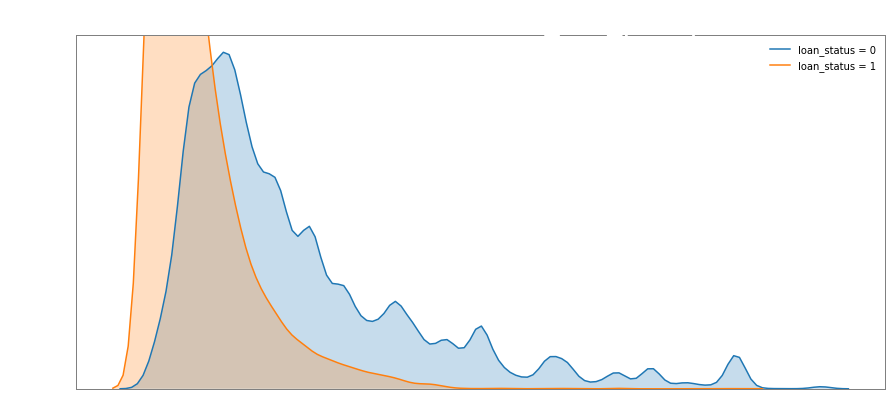

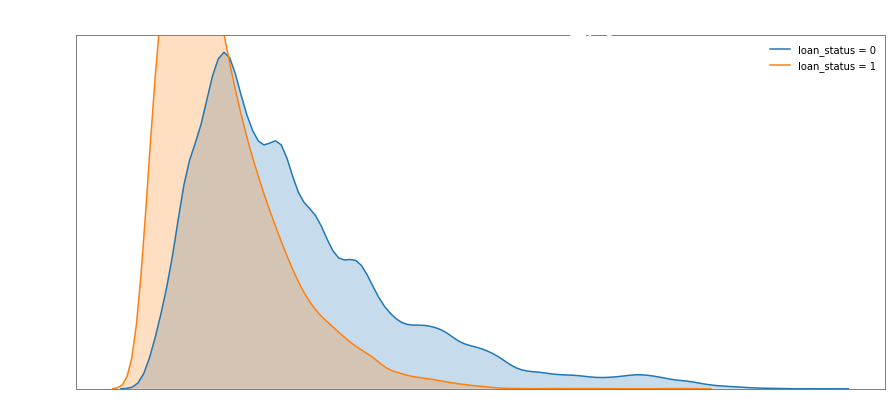

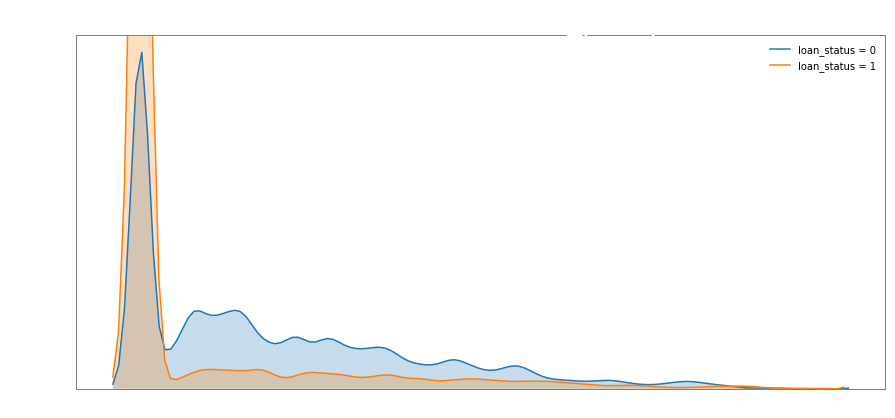

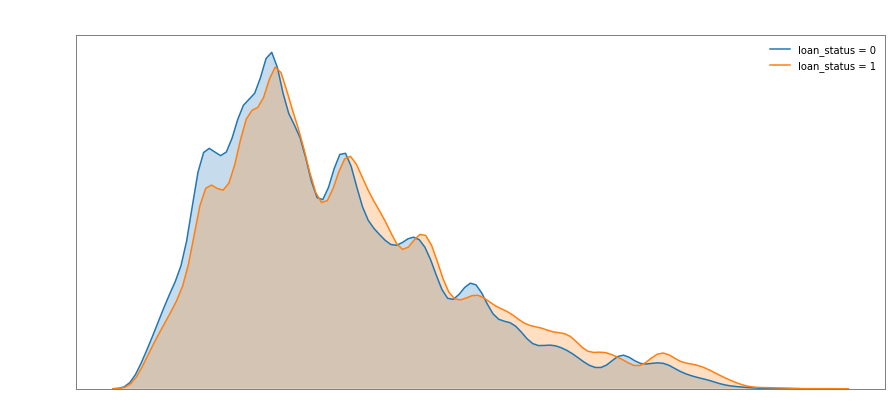

In [13]:
for col in xgb_features['ranked'][:4]:
    data = X_y[[col, target_cols[0]]]
    data.dropna(inplace=True)
    plot_dist(data, col, target_cols[0])

## Plot the first tree

In [14]:
%%time

index_tree = 0
feature_names = [n.replace(' ', '_') for n in xgb_features['names']]
xgb.plot_tree(xgb_model, num_trees=index_tree, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(200, 200)
fig.savefig(r'.\images\tree_n' + str(index_tree) + '_' + version_string + '.png')
plt.show()

Wall time: 39.8 s


## Plot the most important features

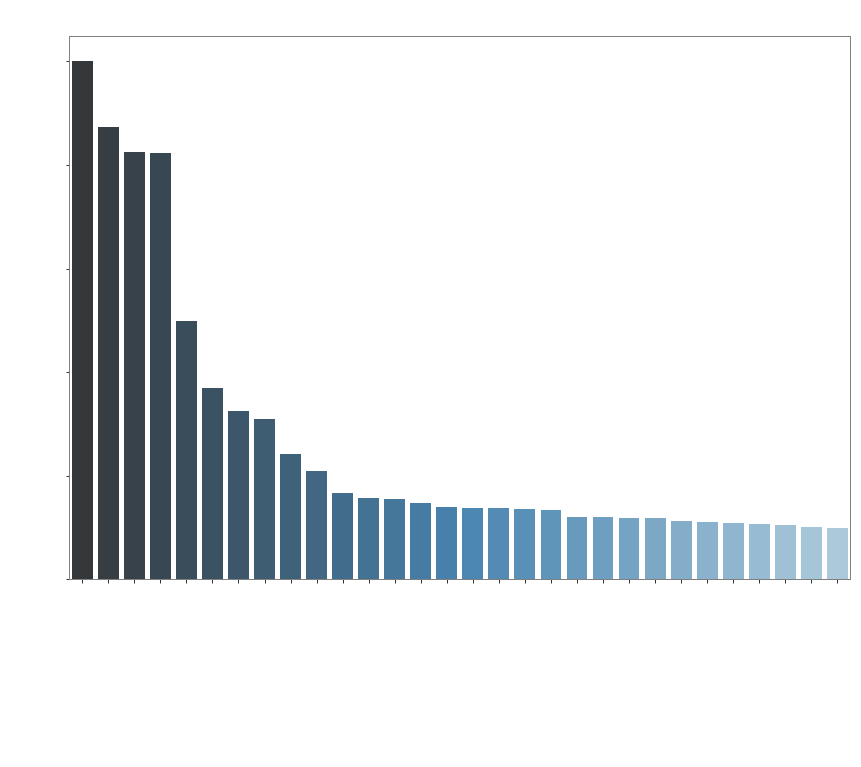

In [15]:
feature_importances = xgb_features['importances']['importance'] / xgb_features['importances']['importance'].max()
feature_names = xgb_features['ranked']
n_shown = 30
rcParams['figure.figsize'] = 14,10
rcParams["axes.labelsize"] = 20
fig = sns.barplot(feature_names[:n_shown], feature_importances[:n_shown], palette='Blues_d')
fig.set_ylabel('Importance (scaled)', color='white')
fig.set_title('Feature Importance', color='white', size=30)
plt.setp(fig.get_xticklabels(), rotation=90, color='white', size=15)
plt.setp(fig.get_yticklabels(), color='white', size=20)
fig.figure.savefig(r'.\images\tree.png')
plt.show()